In [1]:
import tensorflow as tf
from keras.models import Model
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, BatchNormalization
from keras.layers import Input, Conv2D, multiply, LocallyConnected2D, Lambda, Flatten, concatenate
from keras.layers import GlobalAveragePooling2D, AveragePooling2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.utils import plot_model
from keras import optimizers
from keras.metrics import mean_absolute_error
from keras.applications import Xception
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
import seaborn as sns

D:\Applications\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Applications\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Applications\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Applications\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
EPOCHS = 30
LEARNING_RATE = 0.001
BATCH_SIZE_TRAIN = 8
BATCH_SIZE_VAL = 16


PIXELS = 299 # Xception input
CHANNELS = 3
IMG_SIZE = (PIXELS, PIXELS)
IMG_DIMS = (PIXELS, PIXELS, CHANNELS)
VALIDATION_FRACTION = 0.25
SEED = 1234

In [54]:
df.head()

,id,boneage,male,file,exists,boneage_zscore,gender,boneage_category
0,1377,180,False,./input/boneage-training-dataset/1377.png,True,0.639590,0,"(159.9, 182.6]"
1,1378,12,False,./input/boneage-training-dataset/1378.png,True,-1.400135,0,"(0.773, 23.7]"
2,1379,94,False,./input/boneage-training-dataset/1379.png,True,-0.404555,0,"(91.8, 114.5]"
3,1380,120,True,./input/boneage-training-dataset/1380.png,True,-0.088883,1,"(114.5, 137.2]"
4,1381,82,False,./input/boneage-training-dataset/1381.png,True,-0.550249,0,"(69.1, 91.8]"


In [3]:
path = './input/'
train_path = path + 'boneage-training-dataset/'
df = pd.read_csv(path + 'boneage-training-dataset.csv')

files = [train_path + str(i) + '.png' for i in df['id']]
df['file'] = files
df['exists'] = df['file'].map(os.path.exists)

boneage_mean = df['boneage'].mean()
boneage_div = 2 * df['boneage'].std()
df['boneage_zscore'] = df['boneage'].map(lambda x:(x - boneage_mean) / boneage_div)
df.dropna(inplace=True)

df['gender'] = df['male'].map(lambda x: 1 if x else 0)
df['boneage_category'] = pd.cut(df['boneage'], 10)

raw_train_df, raw_valid_df = train_test_split(df, test_size=VALIDATION_FRACTION,random_state=1234, stratify=df['boneage_category'])
train_df = raw_train_df.groupby(['boneage_category', 'male']).apply(lambda x: x.sample(500, replace=True)).reset_index(drop=True)
valid_df, test_df = train_test_split(raw_valid_df,test_size=VALIDATION_FRACTION, random_state=1234)

optim = optimizers.Nadam(lr=LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.0003)
weight_path = "{}_weights_Xception.best.hdf5".format('bone_age')
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,save_best_only=True, mode='min', save_weights_only=True)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, verbose=1, mode='auto', min_delta=0.0001, cooldown=5,min_lr=0.00006)
early = EarlyStopping(monitor="val_loss", mode="min", patience=8)
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [ ]:
def gen_2inputs(imgDatGen, df, batch_size, seed, img_size):
    gen_img = imgDatGen.flow_from_dataframe(dataframe=df,
        x_col='file', y_col='boneage_zscore',
        batch_size=batch_size, seed=seed, shuffle=True, class_mode='other',
        target_size=img_size, color_mode='rgb',
        drop_duplicates=False)
    
    gen_gender = imgDatGen.flow_from_dataframe(dataframe=df,
        x_col='file', y_col='gender',
        batch_size=batch_size, seed=seed, shuffle=True, class_mode='other',
        target_size=img_size, color_mode='rgb',
        drop_duplicates=False)
    
    while True:
        X1i = gen_img.next()
        X2i = gen_gender.next()
        yield [X1i[0], X2i[1]], X1i[1]

def test_gen_2inputs(imgDatGen, df, batch_size, img_size):
    gen_img = imgDatGen.flow_from_dataframe(dataframe=df,
        x_col='file', y_col='boneage_zscore',
        batch_size=batch_size, shuffle=False, class_mode='other',
        target_size=img_size, color_mode='rgb',
        drop_duplicates=False)
    
    gen_gender = imgDatGen.flow_from_dataframe(dataframe=df,
        x_col='file', y_col='gender',
        batch_size=batch_size, shuffle=False, class_mode='other',
        target_size=img_size, color_mode='rgb',
        drop_duplicates=False)
    
    while True:
        X1i = gen_img.next()
        X2i = gen_gender.next()
        yield [X1i[0], X2i[1]], X1i[1]

In [4]:
train_idg = ImageDataGenerator(zoom_range=0.2,
                               fill_mode='nearest',
                               rotation_range=25,  
                               width_shift_range=0.25,  
                               height_shift_range=0.25,  
                               vertical_flip=False, 
                               horizontal_flip=True,
                               shear_range = 0.2,
                               samplewise_center=False, 
                               samplewise_std_normalization=False)

val_idg = ImageDataGenerator(width_shift_range=0.25, 
                             height_shift_range=0.25, 
                             horizontal_flip=True)

test_idg = ImageDataGenerator()

train_flow = gen_2inputs(train_idg, train_df, BATCH_SIZE_TRAIN, SEED, IMG_SIZE)
valid_flow = gen_2inputs(val_idg, valid_df, BATCH_SIZE_VAL, SEED, IMG_SIZE)
test_flow = test_gen_2inputs(test_idg, test_df, 500, IMG_SIZE)

def mae_months(in_gt, in_pred):
    return mean_absolute_error(boneage_div * in_gt, boneage_div * in_pred)

In [5]:
img = Input(shape=IMG_DIMS, name='input_img')
gender = Input(shape=(1,), name='input_gender')

# train the V3 backbone
base = Xception(input_shape=IMG_DIMS, weights='imagenet', include_top=False)

# backbone output
base_out = base(img)
bn_features = BatchNormalization()(base_out)


con_layer = Conv2D(512, kernel_size=(1,1), padding='same', activation='relu')(bn_features)
con_layer = Conv2D(64, kernel_size=(1,1), padding='same', activation='relu')(con_layer)
feature_img = GlobalAveragePooling2D()(con_layer)

# concate with gender
feature_gender = Dense(32, activation='relu')(gender)

# Concatenation
feature = concatenate([feature_img, feature_gender], axis=1)

out = Dense(512, activation='relu')(feature)
out = Dense(512, activation='relu')(out)
out = Dense(1, activation='linear')(out)

model = Model(inputs=[img, gender], outputs=out)

model.compile(loss='mean_absolute_error', optimizer=optim, metrics=[mae_months])
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
xception (Model)                (None, 10, 10, 2048) 20861480    input_img[0][0]                  
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 10, 10, 2048) 8192        xception[1][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 10, 10, 512)  1049088     batch_normalization_5[0][0]      
___________________________________________________________________________________________

In [5]:
# training (DONE)
#
# plot_model(model, show_shapes=True, to_file='model.png')

# BATCH_SIZE_TEST = len(test_df) // 3
# STEP_SIZE_TEST = 3
# STEP_SIZE_TRAIN = len(train_df) // BATCH_SIZE_TRAIN
# STEP_SIZE_VALID = len(valid_df) // BATCH_SIZE_VAL

# model_history = model.fit_generator(generator=train_flow,
#                                     steps_per_epoch=STEP_SIZE_TRAIN, 
#                                     validation_data=valid_flow,
#                                     validation_steps=STEP_SIZE_VALID, 
#                                     epochs=EPOCHS,
#                                     callbacks = callbacks_list)

# loss_history = model_history.history['loss']
# history_df = pd.DataFrame.from_dict(model_history.history)
# history_df.to_csv('loss_history.csv')

83689472/83683744 [==============================] - 9s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
xception (Functional)           (None, 10, 10, 2048) 20861480    input_img[0][0]                  
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 10, 10, 2048) 8192        xception[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 10, 10, 512)  1049088     batch_normalization_4[0][0]      
_____________________________

/home/tyler/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
1250/1250 [==============================] - ETA: 0s - loss: 0.4305 - mae_months: 35.4592Found 2364 validated image filenames.
Found 2364 validated image filenames.
1250/1250 [==============================] - 726s 574ms/step - loss: 0.4304 - mae_months: 35.4516 - val_loss: 0.1537 - val_mae_months: 12.6564

Epoch 00001: val_loss improved from inf to 0.15366, saving model to bone_age_weights.best.hdf5
Epoch 2/30
1250/1250 [==============================] - 716s 573ms/step - loss: 0.1920 - mae_months: 15.8131 - val_loss: 0.1745 - val_mae_months: 14.3721

Epoch 00002: val_loss did not improve from 0.15366
Epoch 3/30
1250/1250 [==============================] - 715s 572ms/step - loss: 0.1617 - mae_months: 13.3193 - val_loss: 0.1261 - val_mae_months: 10.3898

Epoch 00003: val_loss improved from 0.15366 to 0.12614, saving model to bone_age_weights.best.hdf5
Epoch 4/30
1250/1250 [==============================] - 714s 571ms/step - loss: 0.1417 - mae_months: 11.6748 - val_loss: 0.16

Found 789 validated image filenames.
Found 789 validated image filenames.

500/500 [==============================] - 176s 352ms/step


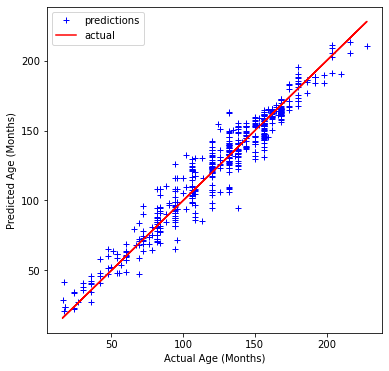

In [6]:
# Testing

model.load_weights("bone_age_weights_Xception.best.hdf5")
test_X, test_Y = next(test_flow)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'DejaVu Sans'
pred_Y = boneage_div*model.predict(test_X, batch_size = 16, verbose = True)+boneage_mean
test_Y_months = boneage_div*test_Y+boneage_mean

fig, ax1 = plt.subplots(1,1,figsize=(6,6))
ax1.plot(test_Y_months, pred_Y, 'b+', label='predictions')
ax1.plot(test_Y_months,test_Y_months,'r-',label='actual')
ax1.legend()
ax1.set_xlabel('Actual Age (Months)')
ax1.set_ylabel('Predicted Age (Months)')
fig.savefig('test_result.png', dpi = 300)

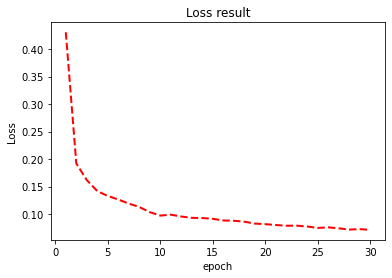

In [16]:
# Plot result: loss and mae generated during training

plot_epoch = [i for i in range(1,31)]
plot_loss = [0.4305,0.192,0.1617,0.1417,0.1328,0.1264,0.119,0.1128,0.1034,0.0971,0.0988,0.0955,0.093,0.0927,0.0913,0.0883,0.0878,0.0861,0.0826,0.0816,0.08,0.0787,0.0788,0.0773,0.0747,0.0758,0.074,0.0717,0.0726,0.0711]
plot_mae = [35.4592,15.8131,13.3193,11.6748,10.9389,10.4104,9.7976,9.2917,8.5136,7.9962,8.1379,7.8691,7.6624,7.637,7.5197,7.2727,7.2309,7.0917,6.8018,6.7197,6.5894,6.48,6.4876,6.3686,6.1524,6.2456,6.0912,5.9069,5.9796,5.8543]

plt.plot(plot_epoch, plot_loss, label="loss", linewidth=2.0,linestyle='--', color='r')

plt.title('Loss result')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.show()

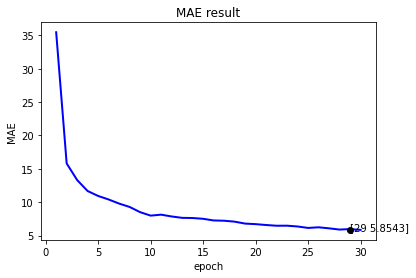

In [21]:
plt.plot(plot_epoch, plot_mae, label="mae", linewidth=2.0,linestyle='-', color='b')
mae_min=np.argmin(plot_mae)
show_min='['+str(mae_min)+' '+str(plot_mae[mae_min])+']'
plt.plot(mae_min,plot_mae[mae_min],'ko')
plt.annotate(show_min,xy=(mae_min,plot_mae[mae_min]),xytext=(mae_min,plot_mae[mae_min]))

plt.title('MAE result')
plt.xlabel('epoch')
plt.ylabel('MAE')
plt.show()